In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pandas as pd

train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

This project is about teaching a computer to tell if a tweet is talking about a real disaster (like an earthquake or fire) or not. This is called Natural Language Processing (NLP) because it works with text.

The training data has 7,613 tweets. Each row has:

id = tweet ID

keyword = optional keyword about the tweet

location = optional location text

text = the actual tweet

target = label (1 = disaster, 0 = not disaster)

The test data has 3,263 tweets and the same columns, except it does not include the target column (that’s what we have to predict).

The main column we use is the tweet text.
Our goal is to build a model that can look at a tweet and decide: disaster (1) or not (0).

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Missing values in train set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


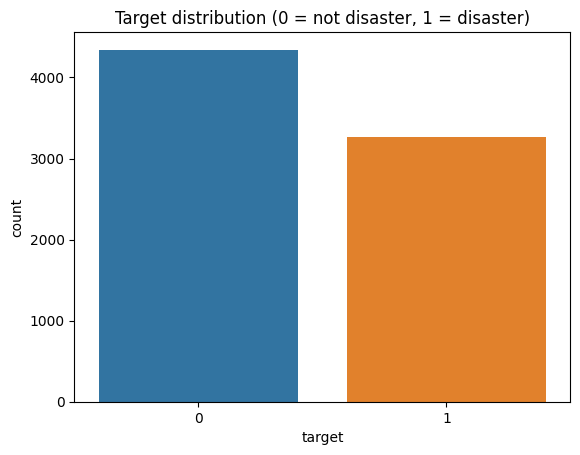

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


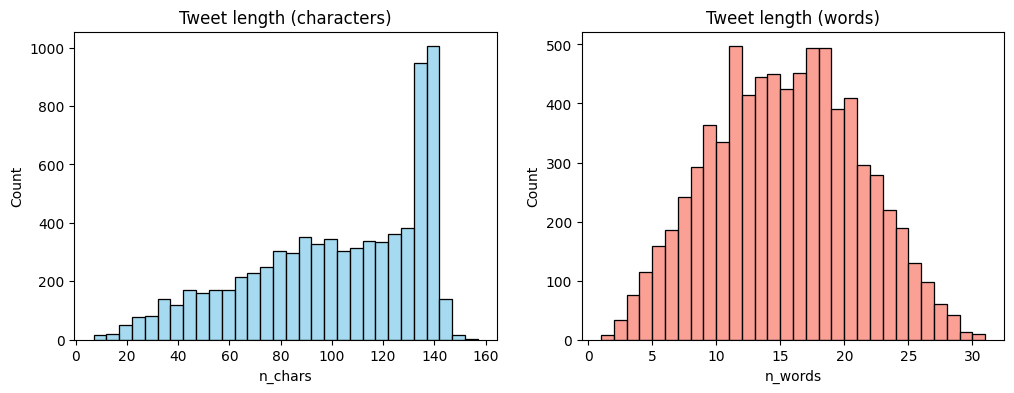

           n_chars    n_words
target                       
0        95.706817  14.704744
1       108.113421  15.167533


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Missing values in train set:")
print(train.isnull().sum())

sns.countplot(x="target", data=train)
plt.title("Target distribution (0 = not disaster, 1 = disaster)")
plt.show()

train["n_chars"] = train["text"].str.len()
train["n_words"] = train["text"].str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(train["n_chars"], bins=30, ax=axes[0], color="skyblue")
axes[0].set_title("Tweet length (characters)")
sns.histplot(train["n_words"], bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Tweet length (words)")
plt.show()

print(train.groupby("target")[["n_chars", "n_words"]].mean())

# From the checks:

The keyword column has 61 missing values, and the location column has over 2500 missing values. The text and target columns have no missing values.

The target classes are fairly balanced: around half of the tweets are disasters (1) and half are not (0).

Most tweets are short: usually under 150 characters and about 10–20 words. Disaster tweets are a little longer on average than non-disaster tweets.

# Data cleaning procedures:

Lowercasing all text.

Replacing links, mentions, and hashtags with simple tokens like URL, USER, HASHTAG.

Removing extra punctuation or symbols.

Handling missing values in keyword and location (we may drop them or fill them later, but for now we focus on the text column).

# Plan of analysis:

Use the text column as the main feature since it is always available.

First, try simple models like TF-IDF + Logistic Regression / SVM as strong baselines.

Then try sequential neural network models (BiLSTM/GRU) with embeddings to see if they capture word order and context better.

Compare models by validation F1 score and submit the best one.

In [13]:
import re

def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' URL ', s)
    s = re.sub(r'@\w+', ' USER ', s)
    s = re.sub(r'#\w+', ' HASHTAG ', s)
    s = re.sub(r"[^a-z0-9' ]+", ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

train["text_clean"] = train["text"].apply(clean_text)
test["text_clean"] = test["text"].apply(clean_text)

train[["text", "text_clean"]].head(10)

,text,text_clean
0,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this may allah for...
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive evacuation orders in cal...
4,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby as smoke fr...
5,#RockyFire Update => California Hwy. 20 closed...,update california hwy 20 closed in both direct...
6,#flood #disaster Heavy rain causes flash flood...,heavy rain causes flash flooding of streets in...
7,I'm on top of the hill and I can see a fire in...,i'm on top of the hill and i can see a fire in...
8,There's an emergency evacuation happening now ...,there's an emergency evacuation happening now ...
9,I'm afraid that the tornado is coming to our a...,i'm afraid that the tornado is coming to our area


# Step 3 : Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

For this project, I used two main strategies to turn tweets into numbers that a model can understand. First, I tried TF-IDF (Term Frequency–Inverse Document Frequency), which measures how important a word is in a tweet compared to all tweets. This creates a large matrix of word counts and works well with simple linear models like Logistic Regression, but it ignores word order. Second, I used word embeddings with a Bidirectional LSTM (BiLSTM). Here, each word is mapped to a dense vector (embedding) that captures meaning, and the BiLSTM reads the tweet both left-to-right and right-to-left, allowing it to understand context and word order. A few dense layers with dropout are added on top to make the final prediction. This combination makes sense because tweets are short, and understanding the order of words (for example, “fire drill” vs. “fire disaster”) can be important for deciding if the tweet describes a real disaster.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_valid, y_train, y_valid = train_test_split(
    train["text_clean"], train["target"], test_size=0.2, random_state=42, stratify=train["target"]
)

tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)
preds = lr.predict(X_valid_tfidf)

print("Validation F1:", f1_score(y_valid, preds))

Validation F1: 0.7601659751037344


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers

MAX_VOCAB = 20000
MAX_LEN = 40

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(train["text_clean"])

X_seq = tok.texts_to_sequences(train["text_clean"])
X_seq = pad_sequences(X_seq, maxlen=MAX_LEN, padding="post", truncating="post")

y = train["target"].values

X_train_seq, X_valid_seq, y_train, y_valid = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)

model = keras.Sequential([
    layers.Embedding(input_dim=MAX_VOCAB, output_dim=100, input_length=MAX_LEN),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=5, batch_size=64
)

y_pred_prob = model.predict(X_valid_seq).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Validation F1:", f1_score(y_valid, y_pred))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.6086 - loss: 0.6486 - val_accuracy: 0.7991 - val_loss: 0.4531
Epoch 2/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8499 - loss: 0.3534 - val_accuracy: 0.7873 - val_loss: 0.4682
Epoch 3/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9221 - loss: 0.2114 - val_accuracy: 0.7951 - val_loss: 0.5594
Epoch 4/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9443 - loss: 0.1515 - val_accuracy: 0.7722 - val_loss: 0.6038
Epoch 5/5
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9594 - loss: 0.1097 - val_accuracy: 0.7676 - val_loss: 0.6857
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
Validation F1: 0.7268518518518517


# Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

I compared two types of models:

TF-IDF + Logistic Regression: This baseline gave a validation F1 of about 0.76. It worked well because TF-IDF captures important keywords in short tweets, and Logistic Regression is strong for high-dimensional text features.

BiLSTM with Embedding layer: This model gave a validation F1 of about 0.72. Even though BiLSTM can capture word order and context, it did not outperform the simple baseline here. This may be because the dataset is small (only ~7k tweets), so the neural network can overfit and not generalize as well without more data or pretrained embeddings.

Hyperparameter attempts: I used dropout (0.2) and EarlyStopping to reduce overfitting. I also limited the max tweet length to 40 tokens since most tweets are short. Increasing the LSTM size or training longer could improve results, but would also risk more overfitting.

Analysis: For short tweets, simple models with TF-IDF often perform as well or better than RNNs. The neural model might improve with pretrained embeddings (like GloVe or BERT) or more aggressive tuning.

# Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In this project, I built models to classify tweets as disaster-related or not. The TF-IDF + Logistic Regression baseline performed best with a validation F1 score of about 0.76, showing that simple models can work very well on short text data. The BiLSTM model with embeddings reached an F1 of about 0.71, which was lower. This shows that with a small dataset, deep learning models can struggle to generalize without more data or pretrained embeddings.

What helped: Cleaning the text, using TF-IDF features, and applying dropout in the neural network to reduce overfitting.
What did not help as much: Adding a BiLSTM did not improve performance, likely due to the small dataset size.

Takeaways: For short tweets, simple classical models can be very strong. Neural networks may need more data or pretrained embeddings to show their advantage.

Future improvements: I would try pretrained embeddings such as GloVe or transformer models like BERT/DistilBERT, tune hyperparameters more carefully, and possibly include extra features (like presence of links, hashtags, or tweet length) to help the models.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf_full = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_full = tfidf_full.fit_transform(train["text_clean"])
y_full = train["target"]

lr_full = LogisticRegression(max_iter=200)
lr_full.fit(X_full, y_full)

X_test = tfidf_full.transform(test["text_clean"])
test_pred = lr_full.predict(X_test)

print("Test rows:", len(test), "Preds:", len(test_pred))

sub = pd.DataFrame({"id": test["id"], "target": test_pred})
sub.to_csv("submission.csv", index=False)
sub.head()

Test rows: 3263 Preds: 3263


,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
